In [1]:
import numpy as np
import torch as t
import os
import matplotlib.pyplot as plt

In [2]:
model_name = "pythia-70m-deduped"
n_feats_per_submod = 512 * 64
n_submod = 6
n_total_feats = n_feats_per_submod * n_submod
random_seed = 42

device = "cuda:0"
num_svd_components = 900 # With 1024 components and percentage 0.9, truncation dim is 805
singular_value_cutoff = 0.95

activations_dir = "/home/can/feature_clustering/activations"
svd_dir = "/home/can/feature_clustering/svd"
loss_threshold = 0.03
skip = 512
num_tokens = 10000
n_pos = 10
submod_type_names = "mlp"


score_metric = "act-grad"
feature_pattern_reduction_across_positions = "sum" # "sum" or "pos"

param_summary = f"{model_name}_tloss{loss_threshold}_ntok{num_tokens}_skip{skip}_npos{n_pos}_{submod_type_names}"
svd_filename = f"svd-comp{num_svd_components}_{score_metric}_{param_summary}.pt"

In [ ]:
# Load feature activations and gradients on 1k contexts
act_grad_filename = f"act-n-grad-cat_{param_summary}.json"
act_per_context = json.load(open(os.path.join(activations_dir, act_grad_filename), "r"))
y_global_idx = np.array(list(act_per_context.keys()), dtype=int)
num_y = len(act_per_context)

X = t.zeros((num_y, n_total_feats))
for row, context in tqdm(enumerate(act_per_context), desc="Loading into matrix, Row", total=num_y):
    for col, act, grad in act_per_context[context][feature_pattern_reduction_across_positions]:
        col = int(col)
        if score_metric == "act":
            X[row, col] = act
        elif score_metric == "act-grad":
            X[row, col] = act * grad
        else:
            raise ValueError("Unknown score_metric")
X.to_sparse().to(device)
print(f'X shape: {X.shape}')
del act_per_context

In [3]:
U, S, V = t.load(os.path.join(svd_dir, svd_filename))

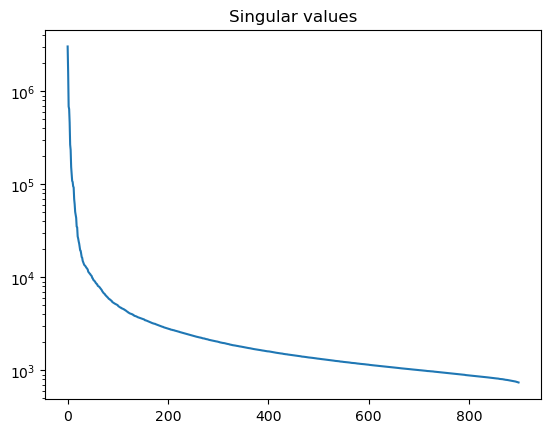

In [4]:
# Plot singular values
plt.plot(S)
plt.title("Singular values")
plt.yscale("log")
plt.show()

In [7]:
# Truncate 
def find_cutoff_index_numpy(a):
    # Step 1: Normalize the array
    normalized_a = a / np.sum(a)

    # Step 2: Find the cutoff index using np.cumsum
    cumulative_sum = np.cumsum(normalized_a)

    # Find the index where cumulative sum exceeds or equals 90%
    cutoff_index = np.argmax(cumulative_sum >= singular_value_cutoff)

    # Step 3: Return the cutoff index
    return cutoff_index

truncation_dim = find_cutoff_index_numpy(S.cpu().numpy())
print(f"Truncation dim: {truncation_dim}")
print(f'full dim: {S.shape[0]}')

Truncation dim: 431
full dim: 900


In [ ]:
# Load_cluster_centroids

In [ ]:
# Take top (10) mechanism vector(s). To which clusters are they closest?
# Whats the distribution of distances to closest to centroids?
svd_dir = "/home/can/feature_clustering/svd"
svd_filename = f"svd-comp900_act_pythia-70m-deduped_tloss0.03_ntok10000_skip512_npos10_mlp.pt"
U, S, V = t.load(os.path.join(svd_dir, svd_filename))

In [ ]:
X_V.shape

torch.Size([1000, 900])

In [ ]:
X_V = t.mm(X, V)
most_important_mechanism = t.argsort(t.abs(X_V), dim=1, descending=True)[:, :2] # Tokens, d_SVD

In [ ]:
most_important_mechanism.unique(return_counts=True, dim=1)

(tensor([[0, 1],
         [0, 1],
         [0, 1],
         ...,
         [0, 2],
         [0, 2],
         [0, 1]]),
 tensor([1, 1]))

In [ ]:
mech = t.tensor([0, 3],)
important_mechanism_mask = (most_important_mechanism == mech).all(dim=1)
gt_idxs = y_global_idx[important_mechanism_mask]

als = defaultdict()
i = 0
for idx in gt_idxs:
    print(contexts_y[str(idx)]["context"])
    print('\n___________________________\n')
    als[contexts_y[str(idx)]["y"]] = contexts_y[str(idx)]["context"]
    i += 1

print(i)

with open("/home/can/feature_clustering/clusters/9900/code_and_math_contexts.json", "w") as f:
    json.dump(als, f)

 y(m) = -3*m. Let n be y(7). Let o = n - -29. List the prime factors of o.
2
Suppose -3*o = 2*o - 35. List the prime factors of o.
7
Suppose 3*o + 5*w = 3*w + 158, -258 = -5*o - 2*w. List the prime factors of o.
2, 5
Let r(v

___________________________

 0. Let k(g) = g**2 - 5*g + 4. Let d be k(t). Solve 2*s + f + 5 = -d, -4*f = -s for s.
-4
Let s be 60/18*9/6. Solve 5*d + 3*z = s, 2*z = -3*d + 6 - 2 for d.
-2
Let o(t) = 3*

___________________________

	</return>
			<argument index="0" name="voice_idx" type="int">
			</argument>
			<description>
			</description>
		</method>
		<method name="get_voice_level_db" qualifiers="const">
			<return type="float">
			</return>
			<argument index="0" name="voice_idx" type="int">
			</argument>
			<

___________________________

/3, q?
-1/3
Suppose 0*o = 3*o - 3. Let l(u) = u**2 + 14*u + 13. Let h be l(-13). Which is the nearest to o?  (a) 1  (b) -3  (c) h
a
Let y = -6 - -5. Let v = -4.99 - 0.01. What is the closest to 0 in y

__________________